The purpose of this project is to predict if a customer will be churning over from a telecommunications provider. I will be using the dataset from https://www.kaggle.com/blastchar/telco-customer-churn for this project.

In [39]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, precision_score, f1_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, auc, confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import numpy as np

from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

Two functions that will be used pretty frequently throughout the project are defined below. 

In [40]:
def model_score(test_pred, train_pred, test_actual, train_actual):
    
    #accuracy
    print('Training Accuracy: {:.4}%'.format(accuracy_score(train_actual, train_pred) * 100))
    print('Validation Accuracy: {:.4}%'.format(accuracy_score(test_actual, test_pred) * 100))

    #precision
    print("Training Precision: {:.4}%".format(precision_score(train_actual, train_pred) * 100))
    print("Validation Precision: {:.4}%".format(precision_score(test_actual, test_pred) * 100))

    #recall
    print('Training Recall: {:.4}%'.format(recall_score(train_actual, train_pred) * 100))
    print('Validation Recall: {:.4}%'.format(recall_score(test_actual, test_pred) * 100))

    #f1
    print('Training F1: {:.4}%'.format(f1_score(train_actual, train_pred) * 100))
    print('Validation F1: {:.4}%'.format(f1_score(test_actual, test_pred) * 100))

def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

The data preprocessing is as follows. The dataset is already pretty clean so there is not much cleaning to actually do, but there is some grouping and converting for a few of the features, due to them containing redundant information. 

In [41]:
df = pd.read_csv('data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce') #there are actually missing values in here,
                                                                        #convert them to NA, then convert them to 0.
df['TotalCharges'] = df['TotalCharges'].fillna(0)
target = df['Churn'].map({'Yes' : 1, 'No' : 0})
features = df.drop(['Churn', 'customerID'], axis=1)

All of the categorical features that include 'No internet service' as one of their options can instead be categorized as simply no, due to that information being contained in a different column.

In [42]:
features['StreamingTV'] = features['StreamingTV'].map({'No internet service': 0, 'Yes' : 1, 'No' : 0})
features['StreamingMovies'] = features['StreamingMovies'].map({'No internet service': 0, 'Yes' : 1, 'No' : 0})
features['OnlineSecurity'] = features['OnlineSecurity'].map({'No internet service': 0, 'Yes' : 1, 'No' : 0})
features['OnlineBackup'] = features['OnlineBackup'].map({'No internet service': 0, 'Yes' : 1, 'No' : 0})
features['DeviceProtection'] = features['DeviceProtection'].map({'No internet service': 0, 'Yes' : 1, 'No' : 0})
features['TechSupport'] = features['TechSupport'].map({'No internet service': 0, 'Yes' : 1, 'No' : 0})
features['Partner'] = features['Partner'].map({'No' : 0, 'Yes' : 1})
features['Dependents'] = features['Dependents'].map({'No' : 0, 'Yes' : 1})
features['PaperlessBilling'] = features['PaperlessBilling'].map({'No' : 0, 'Yes' : 1})
features.drop(['PhoneService'], axis=1, inplace=True)

Grouping up of the categorical features to make dummies for them.

In [43]:
cat_feats = features.drop(['tenure', 'MonthlyCharges', 'TotalCharges'], axis=1 )
cont_feats = features.drop(cat_feats.columns, axis=1)
features_dummies = pd.get_dummies(cat_feats)
df1 = pd.concat([cont_feats, features_dummies], axis=1)

Exploring

In the following figure, there's seemingly a relationship between higher monthly charges and being more likely to churn, as well as the lifetime of the account. Longer accounts seem to be less likely to churn. 

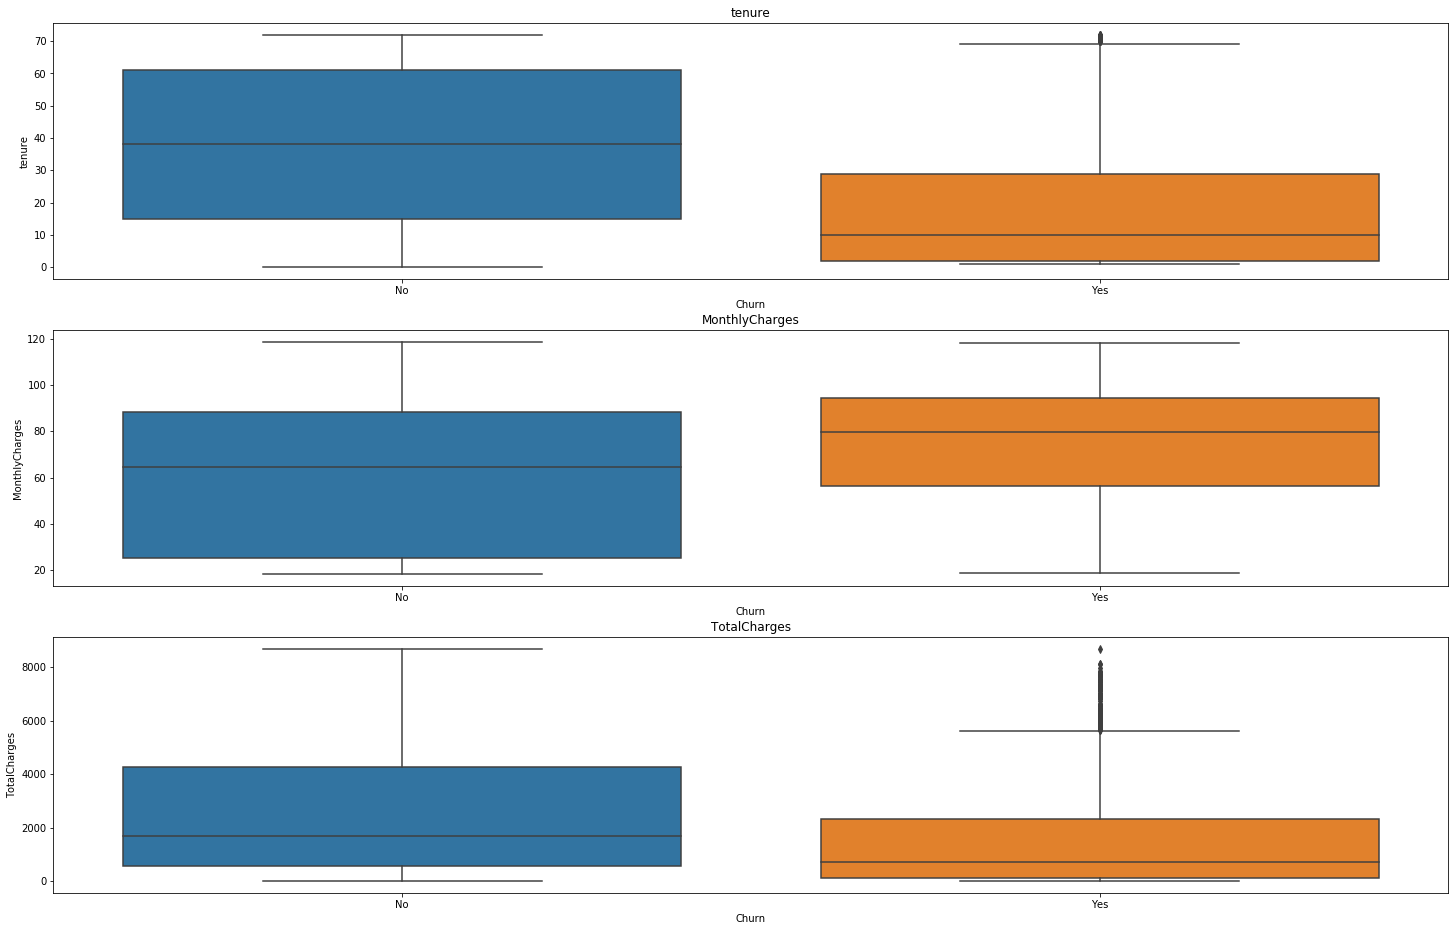

In [44]:
fig, axs = plt.subplots(nrows=3, figsize=(25,16))
n=0
for feat in cont_feats:
    sns.boxplot(x='Churn', y=feat, data = df , ax=axs[n]).set_title(feat)
    n+=1

In these categorical features, these are the ones that look to be the important. Those that pay by electronic check, are single, in a month to month contract, and use paperless billing, seemingly have a relationship with being more likely to churn. If a customer is has all four of these features, there might be a higher possibility that they will be churning.

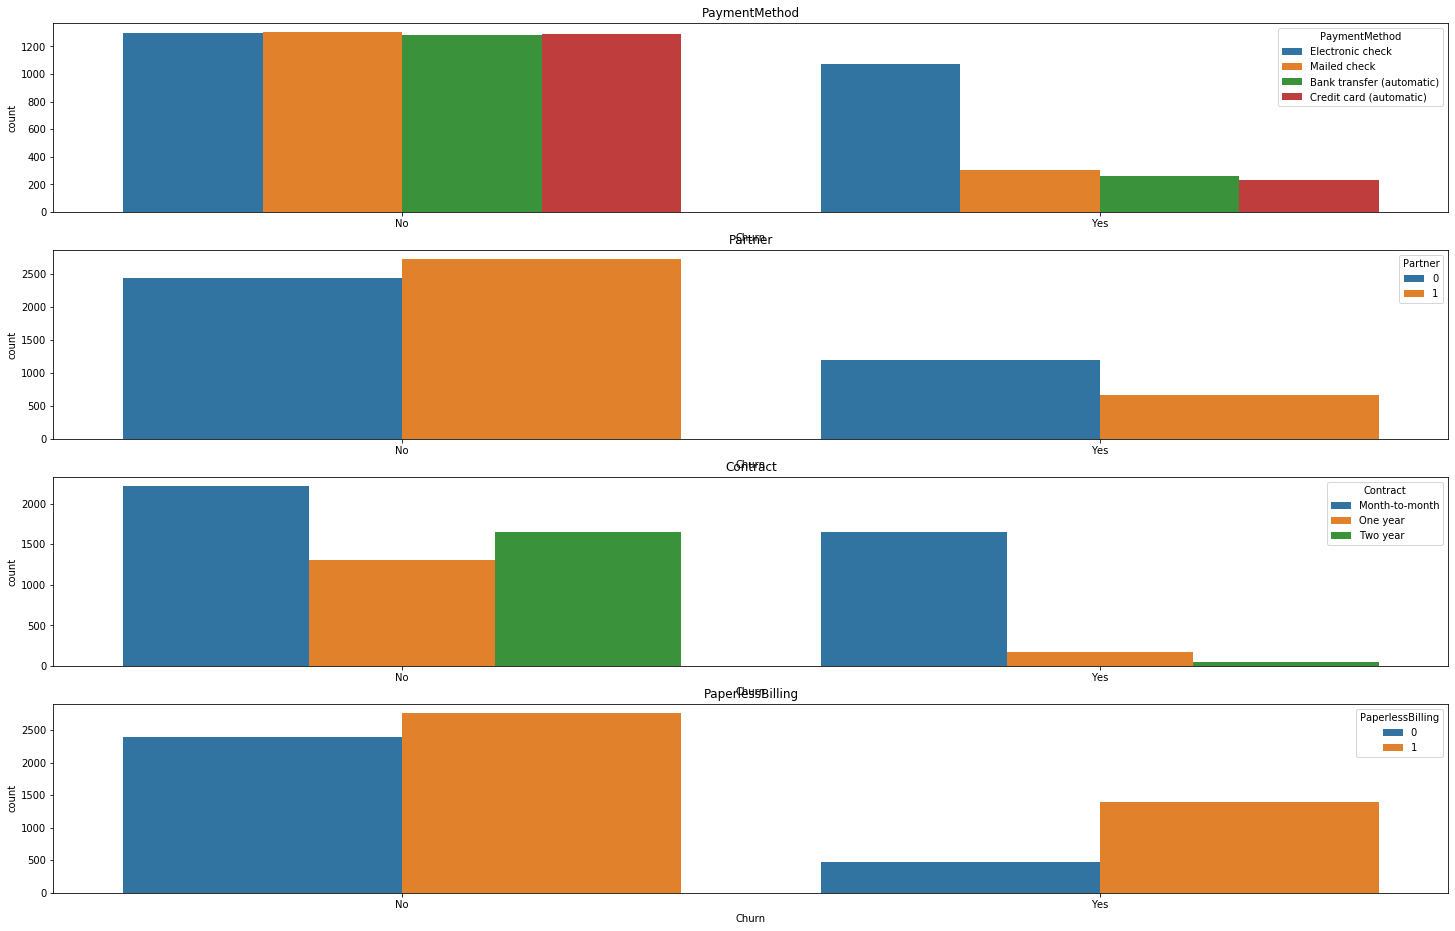

In [45]:
fig, axs = plt.subplots(nrows=4,figsize=(25,16))
n=0
for feat in ['PaymentMethod', 'Partner', 'Contract', 'PaperlessBilling']:
    sns.countplot(x=df['Churn'], hue=features[feat] , ax=axs[n]).set_title(feat)
    n+=1

There's 2 different models that I looked at, and ultimately the one that I think is best will be the second one. The first one uses the continuous features, (monthly charges, total charges, and tenure) as continuous features. While the second one groups each of them into 3 separate groups, low, medium and high. 

Following this is the first model. 

Training Accuracy: 97.59%
Validation Accuracy: 84.69%
Training Precision: 95.58%
Validation Precision: 82.79%
Training Recall: 99.85%
Validation Recall: 86.48%
Training F1: 97.67%
Validation F1: 84.59%


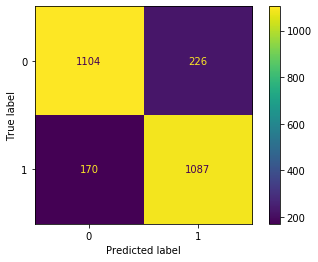

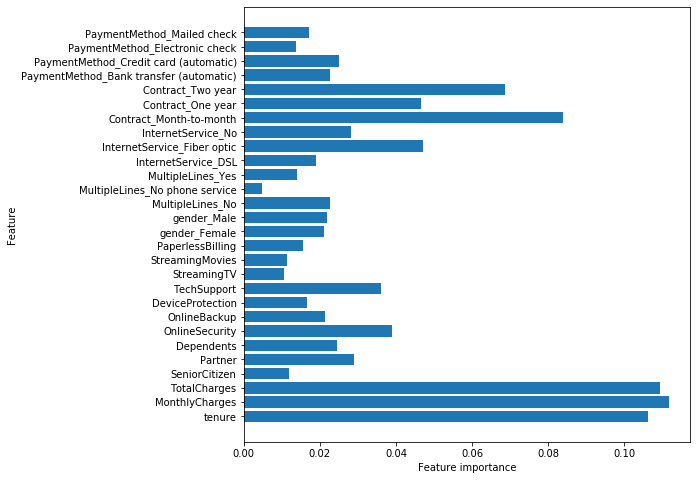

In [46]:
X_resampled, y_resampled = SMOTE().fit_resample(df1, target) 
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=.25, random_state=1)

forest = RandomForestClassifier(criterion='gini', max_depth=15, min_samples_leaf = 1, min_samples_split = 2,
                                n_estimators=100, random_state=1)
forest.fit(X_train, y_train)
train_pred = forest.predict(X_train)
test_pred = forest.predict(X_test)
model_score(test_pred, train_pred, y_test, y_train)
plot_confusion_matrix(forest, X_test, y_test)
plot_feature_importances(forest)

And here is the second. 

In [47]:
cont_feats['MonthlyCharges'] = cont_feats['MonthlyCharges'].apply(lambda x: 'high' if x >= 89.85 else ('medium' if x >= 35.5 else 'low'))
cont_feats['tenure'] = cont_feats['tenure'].apply(lambda x: 'long' if x >= 55 else ('medium' if x >= 9 else 'short'))
cont_feats['TotalCharges'] = cont_feats['TotalCharges'].apply(lambda x: 'high' if x >= 3786.6 else ('medium' if x >= 398.55 else 'low'))
cont_dummies = pd.get_dummies(cont_feats)
df2 = pd.concat([cont_dummies, features_dummies], axis=1)
X_resampled, y_resampled = SMOTE().fit_resample(df2, target) 

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=.25, random_state=1)

Training Accuracy: 88.64%
Validation Accuracy: 82.1%
Training Precision: 85.65%
Validation Precision: 78.28%
Training Recall: 93.08%
Validation Recall: 87.43%
Training F1: 89.21%
Validation F1: 82.6%


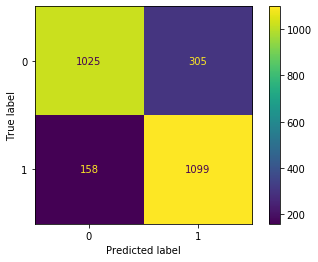

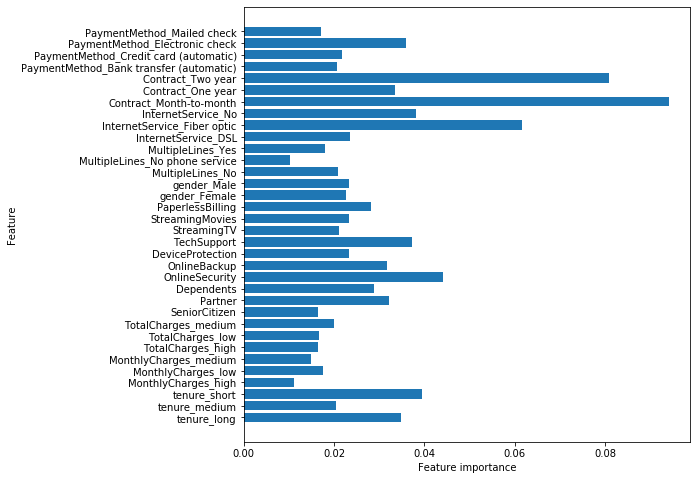

In [48]:
forest = RandomForestClassifier(criterion='entropy', max_depth=15, min_samples_leaf = 2, min_samples_split = 2,
                                n_estimators=150, random_state=1)
forest.fit(X_train, y_train)
train_pred = forest.predict(X_train)
test_pred = forest.predict(X_test)
model_score(test_pred, train_pred, y_test, y_train)
plot_confusion_matrix(forest, X_test, y_test)
plot_feature_importances(forest)

They both perform similarly, but they have different features that are most important. I ultimately chose the second model because it accurately predicted more customers that were going to churn over the first one, and also had less false negatives. 

In [49]:
from sklearn import tree

from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image
import pydotplus

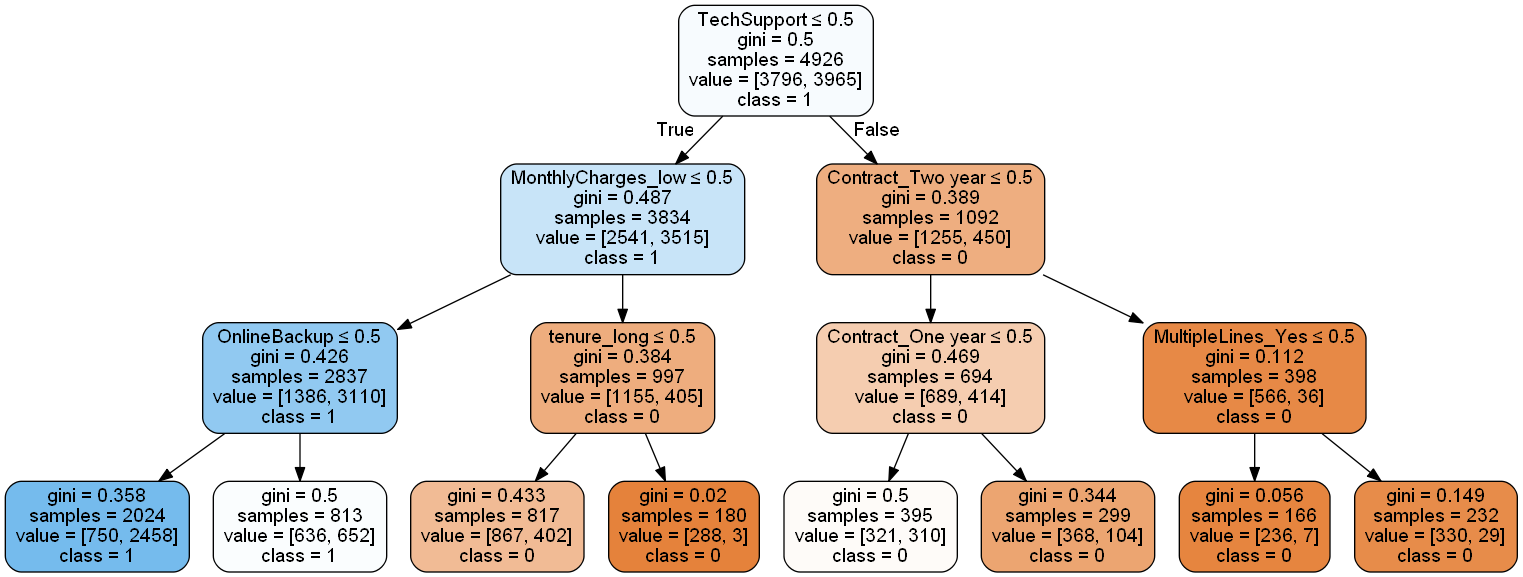

In [71]:
forest = RandomForestClassifier(max_depth=3,n_estimators=150, random_state=1)
forest.fit(X_train, y_train)
estimator = forest.estimators_[5]

col_names = X_train.columns
dot_data = StringIO()
export_graphviz(estimator, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = col_names,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('churn.png')
Image(graph.create_png())

This is where the recommendation will go. Customers that are using the month-to-month contract, have a short tenure (less than 1 year), and pay by electric checks are most likely to churn based on this model. Telco should spend more attention on these customers and perhaps provide them with additional services to entice them away from wanting to leave. There is some evidence that does show that the longer a customer is around, the more likely it is that they will not be churning. 

Future work includes focusing on how much money can be made from a customer before they will churn. Will allow more intelligent business expenditures and prevent waste on customers that aren't going to be spending very much money. 